In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP')
import yaml
import numpy as np
from torch import Tensor
import torch
import matplotlib.pyplot as plt
from run_experiments.prepare_dataset import *
from utils_general import prepare_common_background_info, pred4all_outputs_inputs, evaluate_on_single_output, plot_traindata_testdata_fittedgp, neg_log_likelihood, normalised_mean_square_error
from code_blocks.our_models.lvmogp_svi import LVMOGP_SVI
from code_blocks.likelihoods.gaussian_likelihood import GaussianLikelihood

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
config_name = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/configs/egg/Scale_RBF/lvmogp_unfix.yaml'
model_path = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/experiments_results/egg/Scale_RBF/lvmogp_unfix/2024-03-04_08:11:13/model.pth'
likelihood_path = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/experiments_results/egg/Scale_RBF/lvmogp_unfix/2024-03-04_08:11:13/likelihood.pth'

## Load in model

In [4]:
with open(config_name) as file:
    config = yaml.safe_load(file)

my_model = LVMOGP_SVI(
        n_outputs = config['n_outputs'],
        n_input = config['n_input_train'],                    # NOTE PAY ATTENTION, not total n_inputs.
        input_dim = config['input_dim'],
        latent_dim = config['latent_dim'],
        n_inducing_input = config['n_inducing_input'],
        n_inducing_latent = config['n_inducing_latent'],
        learn_inducing_locations_latent = config['learn_inducing_locations_latent'],
        learn_inducing_locations_input = config['learn_inducing_locations_input'],
        latent_kernel_type = config['latent_kernel_type'],
        input_kernel_type = config['input_kernel_type'],
        trainable_latent_dim = config['trainable_latent_dim'] if 'trainable_latent_dim' in config else None,
        latent_first_init = None,                               # if None, random initialization
        latent_second_init = None,                              # if None, random initialization
        NNEncoder = config['NNEncoder'],
        layers = None                                           # if none, adopt default value [4, 8, 4]
    )   

my_likelihood = GaussianLikelihood()

In [5]:
model_state_dict = torch.load(model_path)
my_model.load_state_dict(model_state_dict)

likelihood_state_dict = torch.load(likelihood_path)
my_likelihood.load_state_dict(likelihood_state_dict)

<All keys matched successfully>

## Load in dataset

In [6]:
if config['dataset_type'] == 'egg':
    data_inputs, data_Y_squeezed, ls_of_ls_train_input, ls_of_ls_test_input, train_sample_idx_ls, test_sample_idx_ls, means, stds = prepare_egg_data(config)
        
n_data4visual = 500
inputs_total4visual = Tensor(np.linspace(0., 1., n_data4visual))

## Test via integration

In [7]:
common_background_information = prepare_common_background_info(my_model, config)

In [8]:
all_pred_mean, all_pred_var = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=data_inputs,
                                                        config=config,
                                                        common_background_information=common_background_information,
                                                        approach='integration')

100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


In [9]:
all_pred_mean4visual, all_pred_var4visual = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=inputs_total4visual,
                                                        config=config,
                                                        common_background_information=common_background_information,
                                                        approach='integration',
                                                        not4visual=False,
                                                        n_data4visual=n_data4visual)


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


In [10]:
train_data_predict = all_pred_mean[train_sample_idx_ls]
train_rmse = (train_data_predict - data_Y_squeezed[train_sample_idx_ls]).square().mean().sqrt()
print('Global Train RMSE via integration', train_rmse)

w_test_data_predict = all_pred_mean[test_sample_idx_ls]
test_rmse = (w_test_data_predict - data_Y_squeezed[test_sample_idx_ls]).square().mean().sqrt()
print('Global Test RMSE via integration', test_rmse)


Global Train RMSE via integration tensor(0.5696)
Global Test RMSE via integration tensor(0.5696)


In [11]:
train_nll = neg_log_likelihood(Target=data_Y_squeezed[train_sample_idx_ls], GaussianMean=all_pred_mean[train_sample_idx_ls], GaussianVar=all_pred_var[train_sample_idx_ls])
test_nll = neg_log_likelihood(Target=data_Y_squeezed[test_sample_idx_ls], GaussianMean=all_pred_mean[test_sample_idx_ls], GaussianVar=all_pred_var[test_sample_idx_ls])

print('Global Train negative log likelihood via integration:', train_nll)
print('Global Test negative log likelihood via integration:', test_nll)

Global Train negative log likelihood via integration: tensor(0.8635)
Global Test negative log likelihood via integration: tensor(0.8641)


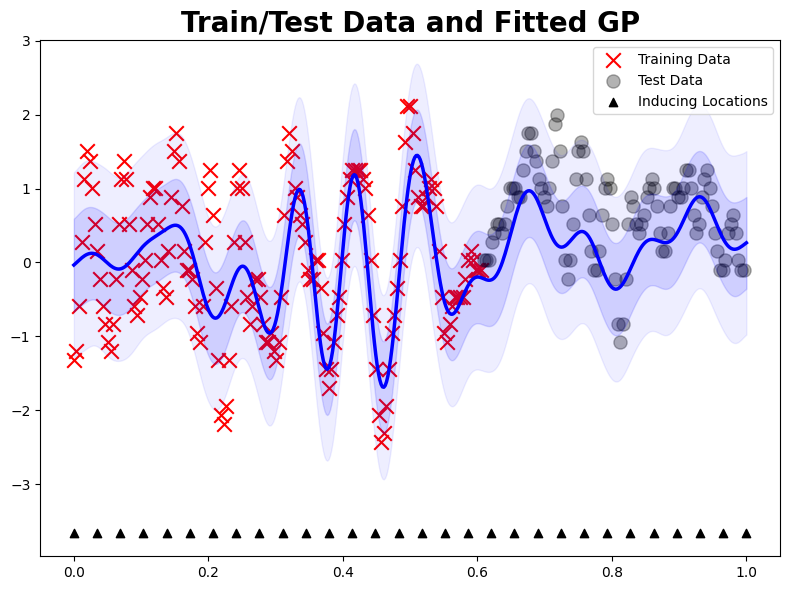

In [15]:
function_index = 1

w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct = evaluate_on_single_output(
                                                        function_index = function_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed, 
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean,
                                                        all_pred_var = all_pred_var,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual,
                                                        all_pred_var4visual = all_pred_var4visual                                                        
                                                        )

plot_traindata_testdata_fittedgp(train_X=w_train_input, 
                                 train_Y=w_train_target, 
                                 test_X=w_test_input, 
                                 test_Y=w_test_target, 
                                 gp_X=inputs_total4visual, 
                                 gp_pred_mean=w_gp_pred_mean, 
                                 gp_pred_std=w_gp_pred_std, 
                                 inducing_points_X=my_model.variational_strategy.inducing_points_input.data, 
                                 n_inducing_C=config['n_inducing_input']) # NOTE: input is C not X